# Ex3 Part 1: One-vs-all

In [1]:
from pathlib import *
%run ../cs229config.py
exppath = str(PurePath(cs229basepath(),'machine-learning-ex3','ex3'))
print("CS229:"+exppath)

CS229:/media/curie/Windows7_OS/data/网络资源-吴恩达机器学习课程/编程作业/machine-learning-ex3/ex3


In [2]:
## Initialization
## Setup the parameters you will use for this part of the exercise
input_layer_size = 400  # 20x20 Input Images of Digits
num_labels = 10         # 10 labels, from 1 to 10
                        # (note that we have mapped "0" to label 10)

## =========== Part 1: Loading and Visualizing Data ===============
  We start the exercise by first loading and visualizing the dataset.
  You will be working with a dataset that contains handwritten digits.

In [3]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
data = loadmat(PurePath(exppath,'ex3data1.mat')) # Load from ex3data1: 
print(data.keys()) # You will have X, y in your environment
# training data stored in arrays X, y
X = data['X']
y = data['y']
m = len(X)
print("X shape:",X.shape,",y shape:",y.shape,",m =",m)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
X shape: (5000, 400) ,y shape: (5000, 1) ,m = 5000


In [4]:
# Randomly select 100 data points to display
# sel = X[np.ceil(np.random.random((1,100))*5000),:}
# rand_indices = np.random.random(100,) * m
# rand_indices = rand_indices.astype(np.int)
import torch
rand_indices = np.array(torch.randperm(m))
sel = X[rand_indices[0:100], :]
print("rand_indices.shape:",rand_indices.shape,", sel.shape:",sel.shape)

rand_indices.shape: (5000,) , sel.shape: (100, 400)


In [5]:
import math
pad = 1
(m,n) = X.shape
# Compute number of items to display
display_rows = math.floor(math.sqrt(m))
display_cols = math.ceil(m / display_rows)
example_width = math.floor(math.sqrt(X.shape[1]))
example_height = n // example_width # 截断除法
display_array = - np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))
display_array.shape

(1471, 1513)

Program paused. Press enter to continue.


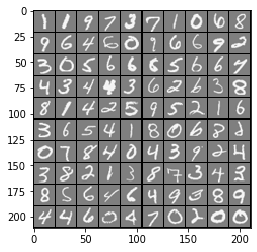

In [6]:
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
# test[0:10,0:10]
# plt.imshow(X[2918].reshape(20,20))
def displayData(X,example_width):
    example_width = math.floor(math.sqrt(X.shape[1]))
    # Gray Image
    plt.gray() # Set the colormap to "gray".
    # Compute rows, cols
    [m,n] = X.shape
    example_height = round(n / example_width)
    # Compute number of items to display
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    # Between images padding
    pad = 1
    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),\
       pad + display_cols * (example_width + pad)))
    # Copy each example into a patch on the display array
    curr_ex = 0 # start from 1 will overflow
    for j in range(display_rows):
        for i in range(display_cols):
            if(curr_ex > m):
                break
            # Copy the patch
            # Get the max value of the patch
            max_val = max(abs(X[1,:]))
            base_r = pad + j * (example_height+pad)
            base_c = pad + i * (example_width+pad)
            # pics = np.array(X[curr_ex,:]).reshape(example_height,example_width)
            pics = np.array(X[curr_ex,:]).reshape(example_height,example_width,\
                order='F')
            display_array[base_r:base_r+example_height,base_c:base_c+example_width] \
            = pics / max_val  
            # matlab的reshape列优先,和python不同 “F”是指用FORTRAN类索引顺序读/写元素
            # [https://www.jianshu.com/p/fc2fe026f002](python基础之numpy.reshape详解)
            # 如果reshape不加order='F'，赋值顺序不对导致图像位置颠倒
            # https://github.com/learning511/cs229-assignments/blob/master/machine-learning-ex3/ex3/displayData.py
            # pics = np.array(X[curr_ex,:]).reshape(example_height,example_width,order='C')
            # display_array[base_r + np.arange(example_height),
            #               base_c + np.arange(example_width)[:, np.newaxis]] =pics/max_val
            curr_ex += 1
        if(curr_ex > m):
            break
    #plt.imshow(display_array,extent=[0,1,0,1])
    plt.imshow(display_array)
    return
%matplotlib inline
displayData(sel,20)
print('Program paused. Press enter to continue.')

## ============ Part 2a: Vectorize Logistic Regression ============
  In this part of the exercise, you will reuse your logistic regression
  code from the last exercise. You task here is to make sure that your
  regularized logistic regression implementation is vectorized. After
  that, you will implement one-vs-all classification for the handwritten
  digit dataset.

In [7]:
# Test case for lrCostFunction
print('Testing lrCostFunction() with regularization')

Testing lrCostFunction() with regularization


In [11]:
theta_t = np.array([-2, -1, 1,2]).reshape(-1,1)
X_t = np.column_stack((np.ones((5,1)),np.arange(1,16).reshape((5,3),order='F') / 10))
y_t = np.array([np.array([1,0,1,0,1]) >= 0.5])
lambda_t = 3

%%latex

in (unregularized) logistic regression, the cost function is
\begin{align}
J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{i}\log(h_\theta(x^{(i)})-(1-y^{(i)})\log(1-h_\theta(x^{(i)}))]
\end{align}
To compute each element in the summation, we have to compute 
$h_\theta(x^{(i)})$ for every example i, where $$h\theta(x^{(i)})=g(\theta^Tx^{(i)})$$ and
$$g(z)=\frac{1}{1+e^{-z}}$$

In [17]:
print("X_t shape:", X_t.shape , "y_t shape:" , y_t.shape , "theta_t shape:" , theta_t.shape )

X_t shape: (5, 4) y_t shape: (1, 5) theta_t shape: (4, 1)


In [77]:
y_t.T*np.log(h_x)+(1-y_t.T)*np.log(h_x)

array([[-0.40318605],
       [-0.34115387],
       [-0.28733533],
       [-0.24100845],
       [-0.20141328]])

In [78]:
np.average(y_t.T*np.log(h_x)+(1-y_t.T)*np.log(h_x))

-0.29481939610974417

In [25]:
def sigmoid(z):
    return np.true_divide(1, 1 + np.exp(-z))
sigmoid(X_t.dot(theta_t))

array([[0.66818777],
       [0.7109495 ],
       [0.75026011],
       [0.78583498],
       [0.81757448]])

In [51]:
-np.log(sigmoid(X_t.dot(theta_t)))

array([[0.40318605],
       [0.34115387],
       [0.28733533],
       [0.24100845],
       [0.20141328]])

In [57]:
y_t.dot(np.log(sigmoid(X_t.dot(theta_t))))

array([[-0.89193465]])

In [58]:
(1-y_t).dot(np.log(1-sigmoid(X_t.dot(theta_t))))

array([[-2.78216233]])

In [29]:
y_t.dot()

array([[2.23602235]])

In [21]:
X_t.dot(theta_t)

array([[0.7],
       [0.9],
       [1.1],
       [1.3],
       [1.5]])

In [90]:
m = y_t.shape[1]
m

5

In [108]:
def sigmoid(z):
    return np.true_divide(1, 1 + np.exp(-z))
sigmoid(X_t.dot(theta_t))

array([[0.66818777],
       [0.7109495 ],
       [0.75026011],
       [0.78583498],
       [0.81757448]])

In [113]:
import math
1/(1+math.e**(-X_t.dot(theta_t)))

array([[0.66818777],
       [0.7109495 ],
       [0.75026011],
       [0.78583498],
       [0.81757448]])

In [115]:
h_x = sigmoid(X_t.dot(theta_t))
h_x

SyntaxError: invalid syntax (<ipython-input-115-b34f2939eaa9>, line 2)

In [117]:
torch.sigmoid(torch.FloatTensor(X_t.dot(theta_t)))

tensor([[0.6682],
        [0.7109],
        [0.7503],
        [0.7858],
        [0.8176]])

In [99]:
-(y_t.T*np.log(h_x))

array([[0.40318605],
       [0.        ],
       [0.28733533],
       [0.        ],
       [0.20141328]])

In [100]:
-(1-y_t.T)*np.log(1-h_x)

array([[-0.        ],
       [ 1.24115387],
       [-0.        ],
       [ 1.54100845],
       [-0.        ]])

In [103]:
h_x = sigmoid(X_t.dot(theta_t))
-(y_t.T*np.log(h_x))-(1-y_t.T)*np.log(1-h_x)

array([[0.40318605],
       [1.24115387],
       [0.28733533],
       [1.54100845],
       [0.20141328]])

In [105]:
h_x

array([[0.66818777],
       [0.7109495 ],
       [0.75026011],
       [0.78583498],
       [0.81757448]])

In [104]:
h_x = sigmoid(X_t.dot(theta_t))
np.average(-(y_t.T*np.log(h_x))-(1-y_t.T)*np.log(1-h_x))

0.7348193961097442

In [95]:
-np.average(np.log(sigmoid(X_t.dot(theta_t)))+y_t.T*np.log(h_x)+(1-y_t.T)*np.log(h_x))

0.5896387922194883

In [79]:
-np.average(np.log(sigmoid(X_t.dot(theta_t)))+y_t.T*np.log(h_x)+(1-y_t.T)*np.log(h_x))

0.5896387922194883

In [86]:
np.sum(lambda_t/(2*5)*(theta_t*theta_t))-np.average(np.log(sigmoid(X_t.dot(theta_t)))+y_t.T*np.log(h_x)+(1-y_t.T)*np.log(h_x))

3.589638792219488

In [33]:
theta_t

array([[-2],
       [-1],
       [ 1],
       [ 2]])

In [38]:
theta_t.T.dot(theta_t)

array([[10]])

In [39]:
(lambda_t/2)* theta_t.T.dot(theta_t)/5

array([[3.]])

In [ ]:
def sigmoid(z):
    return np.true_divide(1, 1 + np.exp(-z))
def lrCostFunction(theta_t, X_t, y_t, lambda_t):
    
    return
lrCostFunction(theta_t,X_t,y_t,lambda_t)

In [ ]:
print('Cost: %f', J)
print('Expected cost: 2.534819\n')
print('Gradients:')
print(' %f ', grad)
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n')

In [ ]:
[J grad] = lrCostFunction(theta_t, X_t, y_t, lambda_t);

## ============ Part 2b: One-vs-All Training =====================

## ================ Part 3: Predict for One-Vs-All ================